# Dataset Creation

In [16]:
import numpy as np
import time
import numpy.random as r
from scipy.io import wavfile as wav
import os
import librosa
import librosa.display as ldisp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.signal as sig
import sounddevice as sd
import re
import shutil

## Create Randomly Generated Audio Tone Samples

In [3]:
sr = 48000 #sample rate
num_files = 10 #number of audio files
sample_length = 5 * sr

start_freq = 10
end_freq = 20000

for i in range(0, num_files):
    audio = np.array([])
    while(len(audio) < sample_length):
        length = int(r.rand() * sr)
        tone = r.rand() * librosa.chirp(1, 20000, sr=sr, length=length)
        noise = r.rand() * (r.rand(len(tone)) - 0.5)
        clicks = 2 * r.rand() * librosa.clicks(np.linspace(0,10, r.randint(10,100)), click_duration=r.rand(), click_freq=r.randint(1, 1000))[:len(tone)]
        t1 = np.linspace(0,2000 * r.rand(),len(tone))
        t2 = np.linspace(0, 2000* r.rand(),len(tone))
        wave1 = r.rand() * sig.square(t1, r.rand())
        wave2 = r.rand() * sig.sawtooth(t2, r.rand())
        audio = np.concatenate((audio, 0.3 * (wave1 + wave2 + tone + noise + clicks)))
    wav.write('AudioFiles_Test/tone{}.wav'.format(i), sr, audio)


/tmp/ipykernel_2267/503287340.py:12: FutureWarning: Pass fmin=1, fmax=20000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  tone = r.rand() * librosa.chirp(1, 20000, sr=sr, length=length)
/tmp/ipykernel_2267/503287340.py:14: FutureWarning: Pass times=[ 0.          0.55555556  1.11111111  1.66666667  2.22222222  2.77777778
  3.33333333  3.88888889  4.44444444  5.          5.55555556  6.11111111
  6.66666667  7.22222222  7.77777778  8.33333333  8.88888889  9.44444444
 10.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  clicks = 2 * r.rand() * librosa.clicks(np.linspace(0,10, r.randint(10,100)), click_duration=r.rand(), click_freq=r.randint(1, 1000))[:len(tone)]
/tmp/ipykernel_2267/503287340.py:14: FutureWarning: Pass times=[ 0.          0.27027027  0.54054054  0.81081081  1.08108108  1.35135135
  1.62162162  1.89189189  2.16216216  2.43243243  2.7027027   2.97297297
  3.24324324

## Create Dataset from audio files

#### Test alginment

In [11]:
print(sd.query_devices())

   0 Pro Tools | Duet: USB Audio (hw:1,0), ALSA (2 in, 4 out)
   1 HDA NVidia: HDMI 0 (hw:2,3), ALSA (0 in, 8 out)
   2 HDA NVidia: HDMI 1 (hw:2,7), ALSA (0 in, 2 out)
   3 HDA NVidia: HDMI 2 (hw:2,8), ALSA (0 in, 8 out)
   4 HDA NVidia: HDMI 3 (hw:2,9), ALSA (0 in, 8 out)
   5 HDA NVidia: HDMI 4 (hw:2,10), ALSA (0 in, 8 out)
   6 HDA NVidia: HDMI 5 (hw:2,11), ALSA (0 in, 8 out)
   7 HDA NVidia: HDMI 6 (hw:2,12), ALSA (0 in, 8 out)
   8 sysdefault, ALSA (128 in, 128 out)
   9 front, ALSA (0 in, 2 out)
  10 surround40, ALSA (0 in, 2 out)
  11 surround51, ALSA (0 in, 2 out)
  12 surround71, ALSA (0 in, 2 out)
  13 iec958, ALSA (0 in, 2 out)
  14 spdif, ALSA (0 in, 2 out)
  15 default, ALSA (128 in, 128 out)
  16 dmix, ALSA (0 in, 2 out)


In [7]:
#Setup audio stream parameters
sd.default.samplerate = 48000
sd.default.device = 0
sd.default.channels = 2
sd.default.blocksize = 1024
sd.default.latency = 0.1
sr = 48000

#Create silence for first part of sample
silence = []

#Create impulse
test_sample = np.concatenate(([1,0,0,-1], np.zeros(12000)))
test_sample = np.concatenate((silence, test_sample[0:sr*2]))
test_sample = np.array([test_sample, (test_sample * -1)]).T

#Measure compressor response
recording = sd.playrec(test_sample, output_mapping=[3, 4], blocking=True)
print(sd.PortAudioError())

#Trim recordings
i = np.argmax(np.abs(recording[:,0] - 0.456) < 0.1)
recording = recording[i:,0]
print(recording[0])
test_sample = test_sample[:len(recording),0]
print(abs(recording[0] - 0.46) < 0.03)

#Save audio
wav.write('input.wav', sr, test_sample)
wav.write('target.wav', sr, recording)


0.4531223773956299
True


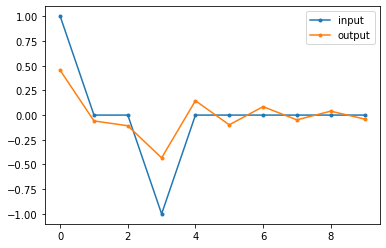

In [8]:
plt.plot(test_sample[:10], label="input", marker = '.')
plt.plot(recording[:10], label="output", marker = '.')
plt.legend()
plt.show()

#### Create Files

In [15]:
#Name of dataset
set_name = 'input11'
sr = 48000
audio_files_path = 'AudioFiles_Test'

path = 'GeneratedDatasets/' + set_name + '/'

#Setup audio stream parameters
sd.default.samplerate = 48000
sd.default.device = 0
sd.default.channels = 2
sd.default.blocksize = 1024
sd.default.latency = 0.1

#parameters to generate training data
silence_gap = np.zeros(2 * sr) #gap between audio samples
sample_length = 2 #length of audio sample 
amplitudes = [0.032, 0.1, 0.32, 0.56, 1, 1.4]
impulse = np.concatenate(([1,0,0,-1], np.zeros(1*sr)))

#iterate over folders
root = os.fsencode(audio_files_path)
count = 1
for folder in os.listdir(root):
    foldername = os.fsdecode(folder)

    if foldername == '.DS_Store':
        continue

    #iterate over files
    directory = os.fsencode(audio_files_path + '/'+ foldername)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)

        if filename == '.DS_Store':
            continue
        
        audio, SR = librosa.load(audio_files_path + '/' + foldername +'/'+ filename, sr=sr, mono=True, duration= 30) #import audio file and convert to 48kHz sample rate. Read first 30 seconds
        if len(audio) > (sample_length + 1) * sr:
            for a in amplitudes:
                #Check file doesn't already exist
                if os.path.isfile(path + 'input{}.wav'.format(count)):
                    count += 1
                    continue

                start = r.randint(0, len(audio) - (sr * (sample_length + 1))) #random start integer
                
                #Record
                while True:
                    time.sleep(3)
                    sample = np.concatenate((impulse, a * audio[start:start + ((sample_length + 1) * sr)]))
                    sample = np.array([sample, (sample * -1)]).T 
                    target = sd.playrec(sample, output_mapping=[3, 4], blocking=True)
                    i = np.argmax(np.abs(target[:,0] - 0.456) < 0.08)
                    target = target[i: i + sample_length * sr + len(impulse), 0]
                    sample = sample[:len(target),0]

                    if abs(target[0] - 0.456) < 0.08:
                        target = target[len(impulse):]
                        sample = sample[len(impulse):]
                        break
                    else:
                        print("Misaligned, index {} retrying...".format(i))
                        time.sleep(3)

                    
                wav.write(path + 'input{}.wav'.format(count), sr, sample.astype(np.float32))
                wav.write(path + 'target{}.wav'.format(count), sr, target.astype(np.float32))

                count += 1

        else:
            print("Too short {}".format(len(audio)/sr))


Too short 2.5838958333333335
Too short 0.9248333333333333
Too short 0.7645
Too short 0.8893125
Too short 0.8
Too short 0.8902291666666666
Too short 0.8469166666666667
Too short 0.8248333333333333
Too short 0.63125
Misaligned, index 0 retrying...
Too short 0.7797291666666667


## Split Dataset Into Train, val and test

In [20]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#Path to dataset samples
path = "GeneratedDatasets/input10/"
out_path = "GeneratedDatasets/out"
train_split = 0.8
val_split = 0.1
test_split = 0.1

files = sorted_alphanumeric(os.listdir(path))
num_samples = int(files[-1][6:-4])

#Generate indices
indices = np.linspace(1, num_samples, num_samples)
indices = indices.astype(np.int64)
np.random.shuffle(indices)
train_indices = indices[:int(train_split * num_samples)]
val_indices = indices[int(train_split * num_samples):int((train_split + val_split) * num_samples)]
test_indices = indices[int((train_split + val_split) * num_samples):]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

#Copy train files
for i, index in enumerate(train_indices):
    shutil.copy(path + "input{}.wav".format(index), out_path + "/train/input{}.wav".format(i))
    shutil.copy(path + "target{}.wav".format(index), out_path + "/train/target{}.wav".format(i))

#Copy val files
for i, index in enumerate(val_indices):
    shutil.copy(path + "input{}.wav".format(index), out_path + "/val/input{}.wav".format(i))
    shutil.copy(path + "target{}.wav".format(index), out_path + "/val/target{}.wav".format(i))

#Copy test files
for i, index in enumerate(test_indices):
    shutil.copy(path + "input{}.wav".format(index), out_path + "/test/input{}.wav".format(i))
    shutil.copy(path + "target{}.wav".format(index), out_path + "/test/target{}.wav".format(i))


2280
285
285
